In [95]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import geopandas as gpd
import nomad.visit_attribution as va
import nomad.filters as filters
import matplotlib.pyplot as plt

In [97]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)
sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)
user1 = diaries_df.uid.unique()[0]
user2 = diaries_df.uid.unique()[10]
diary1 = diaries_df.loc[diaries_df.uid == user1]
diary2 = diaries_df.loc[diaries_df.uid == user2]

In [90]:
completeness_df = filters.q_stats(sparse_df, 'uid', 'timestamp')

In [93]:
completeness_df

,uid,q_stat
0,adoring_keldysh,0.450864
1,adoring_newton,0.484933
2,adoring_swartz,0.593303
3,affectionate_benz,0.363530
4,affectionate_franklin,0.416544
...,...,...
95,sad_curie,0.185028
96,serene_kirch,0.385532
97,sharp_sammet,0.422907
98,sleepy_borg,0.245338


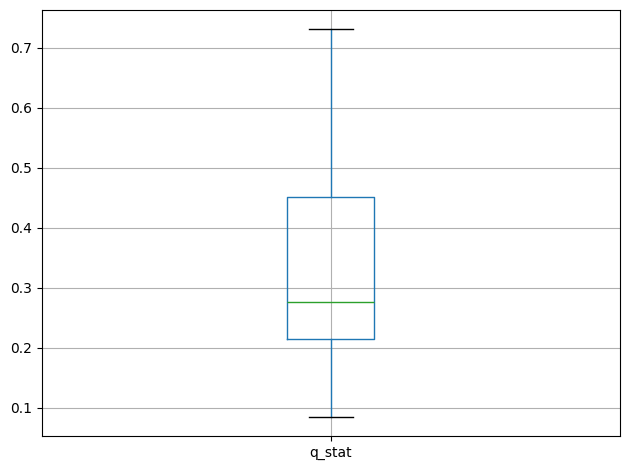

In [ ]:
plt.figure()
completeness_df.boxplot(column="q_stat")
plt.grid(True)
plt.tight_layout()

plt.show()

In [98]:
def overlapping_visits(df1, df2, match_location=False):
    df1 = df1.loc[~df1.location.isna()].copy()
    df2 = df2.loc[~df2.location.isna()].copy()
    df1.rename(columns={'start_timestamp': 'timestamp'}, inplace=True)
    # Raise error if either df has more than one distinct uid
    for df in (df1, df2):
        if 'uid' in df.columns and df['uid'].nunique() > 1:
            raise ValueError("Each dataframe must have at most one unique uid")
    keep_uid = ('uid' in df1.columns and 'uid' in df2.columns 
                and df1['uid'].iloc[0] != df2['uid'].iloc[0])

    df1['end_timestamp'] = df1['timestamp'] + df1['duration'] * 60
    df2['end_timestamp'] = df2['timestamp'] + df2['duration'] * 60

    if match_location:
        df1 = df1[df1['location'].notna()]
        df2 = df2[df2['location'].notna()]
        merged = df1.merge(df2, on='location', suffixes=('_left','_right'))
    else:
        merged = df1.merge(df2, how='cross', suffixes=('_left','_right'))

    cond = (
        (merged['timestamp_left'] < merged['end_timestamp_right']) &
        (merged['timestamp_right'] < merged['end_timestamp_left'])
    )
    merged = merged.loc[cond]

    start_max = merged[['timestamp_left','timestamp_right']].max(axis=1)
    end_min   = merged[['end_timestamp_left','end_timestamp_right']].min(axis=1)
    merged['overlap_duration'] = ((end_min - start_max) // 60).astype(int)

    if match_location:
        cols = ['timestamp_left','timestamp_right','location','overlap_duration']
    else:
        cols = ['timestamp_left','timestamp_right','location_left','location_right','overlap_duration']
    if keep_uid:
        cols += ['uid_left','uid_right']

    return merged[cols].reset_index(drop=True)

def compute_visitation_errors(overlaps, truth_df):
    n_truth = truth_df['timestamp'].nunique()
    gt_overlapped = set(overlaps['timestamp_right'].unique())
    missed = (n_truth - len(gt_overlapped)) / n_truth

    merged_ids = set()
    for pred_ts, group in overlaps.groupby('timestamp_left'):
        if group['location_right'].nunique() > 1:
            merged_ids.update(group['timestamp_right'].unique())
    merged = len(merged_ids) / n_truth

    split_ids = set()
    same_loc = overlaps[overlaps['location_left'] == overlaps['location_right']]
    for gt_ts, group in same_loc.groupby('timestamp_right'):
        if group['timestamp_left'].nunique() > 1:
            split_ids.add(gt_ts)
    split = len(split_ids) / n_truth

    return {'missed_fraction': missed,
            'merged_fraction': merged,
            'split_fraction': split}

def compute_precision_recall_f1(overlaps, pred_df, truth_df):
    total_pred = pred_df['duration'].sum()
    total_truth = truth_df['duration'].sum()

    tp = overlaps.loc[
        overlaps['location_left'] == overlaps['location_right'],
        'overlap_duration'
    ].sum()

    precision = tp / total_pred if total_pred > 0 else 0.0
    recall = tp / total_truth if total_truth > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return {'precision': precision,
            'recall': recall,
            'f1': f1}

In [99]:
sparse1 = sparse_df[sparse_df['uid'] == 'adoring_keldysh']
sparse1.loc[:,'x'] = (sparse1['x'] - 4265699)/15
sparse1.loc[:,'y'] = (sparse1['y'] + 4392976)/15
sparse1

,uid,timestamp,longitude,latitude,x,y,local_timestamp,ha,date
0,adoring_keldysh,1704093060,38.321357,-36.666491,14.333499,16.979319,2024-01-01 09:11:00+02:00,11.25,2024-01-01
1,adoring_keldysh,1704094080,38.321313,-36.666492,14.003855,16.966934,2024-01-01 09:28:00+02:00,11.25,2024-01-01
2,adoring_keldysh,1704094500,38.321364,-36.666583,14.383177,16.123239,2024-01-01 09:35:00+02:00,11.25,2024-01-01
3,adoring_keldysh,1704094620,38.321359,-36.666541,14.341189,16.513853,2024-01-01 09:37:00+02:00,11.25,2024-01-01
4,adoring_keldysh,1704095100,38.321314,-36.666566,14.007852,16.285758,2024-01-01 09:45:00+02:00,11.25,2024-01-01
...,...,...,...,...,...,...,...,...,...
24968,adoring_keldysh,1704705420,38.321292,-36.666521,13.848624,16.696345,2024-01-08 11:17:00+02:00,11.25,2024-01-08
24969,adoring_keldysh,1704705900,38.321341,-36.666562,14.214039,16.320675,2024-01-08 11:25:00+02:00,11.25,2024-01-08
24970,adoring_keldysh,1704706920,38.321406,-36.666544,14.691927,16.489622,2024-01-08 11:42:00+02:00,11.25,2024-01-08
24971,adoring_keldysh,1704707640,38.321465,-36.666517,15.134449,16.737628,2024-01-08 11:54:00+02:00,11.25,2024-01-08


In [100]:
diary1.loc[:,'x'] = (diary1['x'] - 4265699)/15
diary1.loc[:,'y'] = (diary1['y'] + 4392976)/15
diary1

,timestamp,longitude,latitude,x,y,date,local_timestamp,duration,location,uid
0,1704081660,38.320976,-36.667515,11.5,7.5,2024-01-01,2024-01-01 06:01:00+02:00,120,h-x11-y8,adoring_keldysh
1,1704088860,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 08:01:00+02:00,4,None,adoring_keldysh
2,1704089100,38.321380,-36.666543,14.5,16.5,2024-01-01,2024-01-01 08:05:00+02:00,236,w-x14-y15,adoring_keldysh
3,1704103260,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 12:01:00+02:00,3,None,adoring_keldysh
4,1704103440,38.322121,-36.667029,20.0,12.0,2024-01-01,2024-01-01 12:04:00+02:00,12,r-x18-y11,adoring_keldysh
...,...,...,...,...,...,...,...,...,...,...
146,1704644460,38.320976,-36.667515,11.5,7.5,2024-01-07,2024-01-07 18:21:00+02:00,505,h-x11-y8,adoring_keldysh
147,1704674760,NaN,NaN,NaN,NaN,2024-01-08,2024-01-08 02:46:00+02:00,3,None,adoring_keldysh
148,1704674940,38.321110,-36.666759,12.5,14.5,2024-01-08,2024-01-08 02:49:00+02:00,312,h-x12-y13,adoring_keldysh
149,1704693660,NaN,NaN,NaN,NaN,2024-01-08,2024-01-08 08:01:00+02:00,4,None,adoring_keldysh


In [82]:
DUR_MIN=5
DT_MAX=60
DELTA_ROAM=5

stop_table_lachesis = LACHESIS.lachesis(traj=sparse1,
                                        dur_min=DUR_MIN,
                                        dt_max=DT_MAX,
                                        delta_roam=DELTA_ROAM,
                                        traj_cols=traj_cols,
                                        keep_col_names=True,
                                        complete_output=True)

labels_lachesis = LACHESIS._lachesis_labels(traj=sparse1,
                                            dur_min=DUR_MIN,
                                            dt_max=DT_MAX,
                                            delta_roam=DELTA_ROAM,
                                            traj_cols=traj_cols)
labels_lachesis.name = 'cluster'

pred_lachesis = va.point_in_polygon(traj=sparse1,
                 labels=labels_lachesis,
                 stop_table=stop_table_lachesis,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

pred_lachesis.location.nunique()

# truth_df = diary1

# va.majority_poi(traj=sparse1,
#              labels=labels_lachesis,
#              stop_table=stop_table_lachesis,
#              traj_cols=traj_cols,
#              is_datetime=False,
#              is_long_lat=False)

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


16

In [ ]:
stop_table_hdbscan = HDBSCAN.st_hdbscan(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=60,
                min_pts=2,
                min_cluster_size=3)

labels_hdbscan = HDBSCAN.hdbscan_labels(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=60,
                min_pts=2,
                min_cluster_size=3)

labels_hdbscan.name = 'cluster'

pred_hdbscan = va.point_in_polygon(traj=sparse1,
                 labels=labels_hdbscan,
                 stop_table=stop_table_hdbscan,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

pred_hdbscan.location.nunique()

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


19

In [81]:
len(pred_hdbscan)

50

In [75]:
diary1.location.nunique()

36

In [42]:
# Step 1: Compute overlaps
overlaps = overlapping_visits(df1=pred_df,
                              df2=truth_df,
                              match_location=False)

# Step 2: Compute visitation errors (missed, merged, split)
errors = compute_visitation_errors(overlaps=overlaps,
                                   truth_df=truth_df)
print("Visitation Errors:", errors)

# Step 3: Compute precision, recall, and F1
prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                   pred_df=pred_df,
                                   truth_df=truth_df)
print("Precision / Recall / F1:", prf1)

Visitation Errors: {'missed_fraction': 0.8079470198675497, 'merged_fraction': 0.059602649006622516, 'split_fraction': 0.026490066225165563}
Precision / Recall / F1: {'precision': np.float64(0.8615492464072906), 'recall': np.float64(0.23544061302681993), 'f1': np.float64(0.3698187015722561)}


In [ ]:
stop_table_hdbscan = HDBSCAN.st_hdbscan(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=60,
                min_pts=2,
                min_cluster_size=3
            )

labels_hdbscan = HDBSCAN.hdbscan_labels(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=60,
                min_pts=2,
                min_cluster_size=3
            )

labels_hdbscan.name = 'cluster'

va.point_in_polygon(traj=sparse1,
                 labels=labels_hdbscan,
                 stop_table=stop_table_hdbscan,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

In [101]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
stop_detection_algos = ['lachesis', 'ta-dbscan', 'hdbscan']
metrics_df = pd.DataFrame()
TIME_THRESH=60
DIST_THRESH=5
MIN_PTS=2

DUR_MIN=5
DT_MAX=60
DELTA_ROAM=3

for user in diaries_df.uid.unique():
    # truth_df = diaries_df.loc[diaries_df.uid == user].dropna().reset_index(drop=True)
    sparse = sparse_df[sparse_df['uid'] == user]
    sparse.loc[:,'x'] = (sparse['x'] - 4265699)/15
    sparse.loc[:,'y'] = (sparse['y'] + 4392976)/15
    
    truth = diaries_df.loc[diaries_df['uid'] == user]
    truth.loc[:,'x'] = (truth['x'] - 4265699)/15
    truth.loc[:,'y'] = (truth['y'] + 4392976)/15

    for algo in stop_detection_algos:
        if algo == 'lachesis':
            stop_table = LACHESIS.lachesis(
                traj=sparse,
                dur_min=DUR_MIN,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols
            )
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dur_min=5,
                dt_max=60,
                delta_roam=3,
                traj_cols=traj_cols
            )
            labels.name = 'cluster'
            # print(algo)
            # print(stop_table)
            # print(labels)
        elif algo == 'ta-dbscan':
            stop_table = TADBSCAN.temporal_dbscan(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols
            )
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols
            )
            labels.name = 'cluster'
            # print(algo)
            # print(stop_table)
            # print(labels)
        else:  # 'hdbscan'
            stop_table = HDBSCAN.st_hdbscan(
                traj=sparse,
                traj_cols=traj_cols,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3
            )
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                traj_cols=traj_cols,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3
            )
            labels.name = 'cluster'
            # print(algo)
            # print(stop_table)
            # print(labels)
        
        pred = va.point_in_polygon(traj=sparse,
                 labels=labels,
                 stop_table=stop_table,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

        # Step 1: Compute overlaps
        overlaps = overlapping_visits(df1=pred,
                                      df2=truth,
                                      match_location=False)

        # Step 2: Compute visitation errors (missed, merged, split)
        errors = compute_visitation_errors(overlaps=overlaps,
                                           truth_df=truth)

        # Step 3: Compute precision, recall, and F1
        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_df=pred,
                                           truth_df=truth)

        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        metrics_df = pd.concat([metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory co

In [85]:
sparse_df

,uid,timestamp,longitude,latitude,x,y,local_timestamp,ha,date
0,adoring_keldysh,1704093060,38.321357,-36.666491,4.265914e+06,-4.392721e+06,2024-01-01 09:11:00+02:00,11.25,2024-01-01
1,adoring_keldysh,1704094080,38.321313,-36.666492,4.265909e+06,-4.392721e+06,2024-01-01 09:28:00+02:00,11.25,2024-01-01
2,adoring_keldysh,1704094500,38.321364,-36.666583,4.265915e+06,-4.392734e+06,2024-01-01 09:35:00+02:00,11.25,2024-01-01
3,adoring_keldysh,1704094620,38.321359,-36.666541,4.265914e+06,-4.392728e+06,2024-01-01 09:37:00+02:00,11.25,2024-01-01
4,adoring_keldysh,1704095100,38.321314,-36.666566,4.265909e+06,-4.392732e+06,2024-01-01 09:45:00+02:00,11.25,2024-01-01
...,...,...,...,...,...,...,...,...,...
26844,stoic_johnson,1704702600,38.320663,-36.667877,4.265837e+06,-4.392914e+06,2024-01-08 10:30:00+02:00,11.25,2024-01-08
26845,stoic_johnson,1704702720,38.320646,-36.667780,4.265835e+06,-4.392900e+06,2024-01-08 10:32:00+02:00,11.25,2024-01-08
26846,stoic_johnson,1704702780,38.320632,-36.667780,4.265833e+06,-4.392900e+06,2024-01-08 10:33:00+02:00,11.25,2024-01-08
26847,stoic_johnson,1704702840,38.320698,-36.667836,4.265841e+06,-4.392908e+06,2024-01-08 10:34:00+02:00,11.25,2024-01-08


In [83]:
metrics_df

,missed_fraction,merged_fraction,split_fraction,precision,recall,f1,user,algorithm
0,0.814570,0.026490,0.046358,0.983660,0.259483,0.410641,adoring_keldysh,lachesis
1,0.794702,0.112583,0.019868,0.577695,0.162739,0.253942,adoring_keldysh,ta-dbscan
2,0.814570,0.019868,0.072848,0.878351,0.204023,0.331131,adoring_keldysh,hdbscan
3,0.803922,0.052288,0.078431,0.973418,0.249042,0.396614,adoring_newton,lachesis
4,0.797386,0.111111,0.039216,0.727991,0.194061,0.306436,adoring_newton,ta-dbscan
...,...,...,...,...,...,...,...,...
295,0.874172,0.052980,0.013245,0.924615,0.115134,0.204770,sleepy_borg,ta-dbscan
296,0.880795,0.019868,0.019868,0.899527,0.145785,0.250907,sleepy_borg,hdbscan
297,0.847682,0.000000,0.026490,0.990599,0.161494,0.277714,stoic_johnson,lachesis
298,0.847682,0.046358,0.006623,0.706113,0.120594,0.206005,stoic_johnson,ta-dbscan


<Figure size 640x480 with 0 Axes>

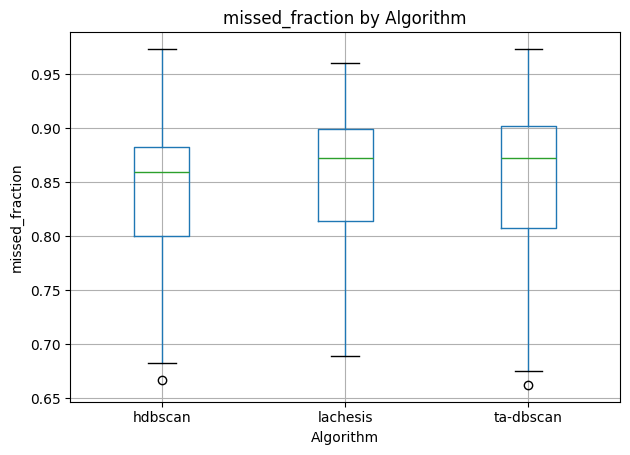

<Figure size 640x480 with 0 Axes>

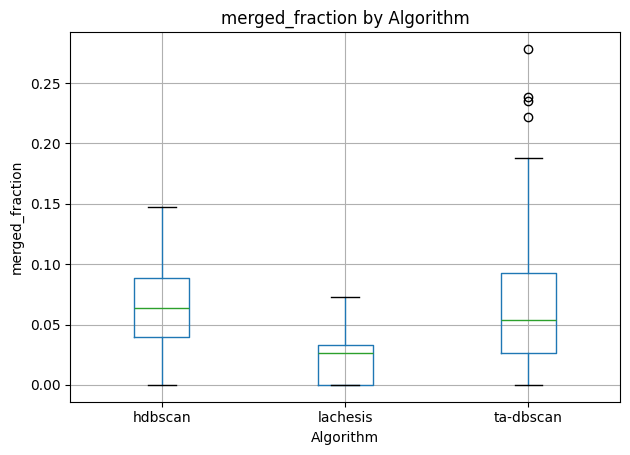

<Figure size 640x480 with 0 Axes>

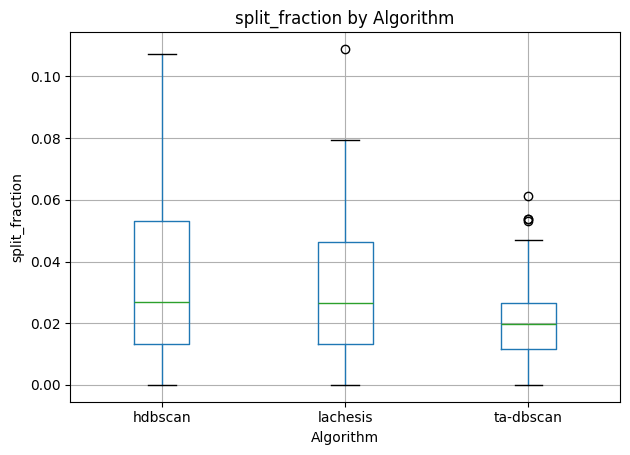

<Figure size 640x480 with 0 Axes>

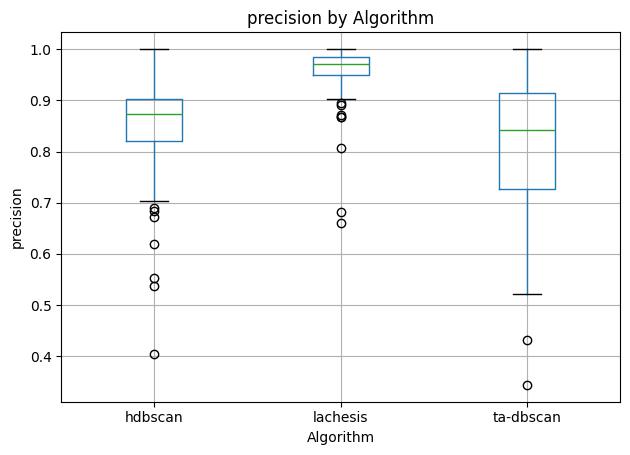

<Figure size 640x480 with 0 Axes>

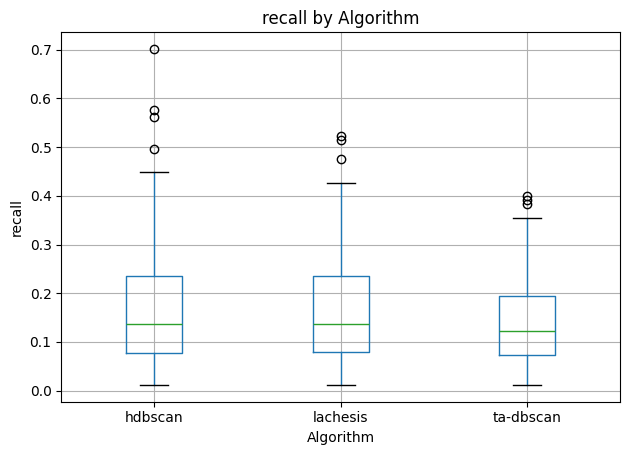

<Figure size 640x480 with 0 Axes>

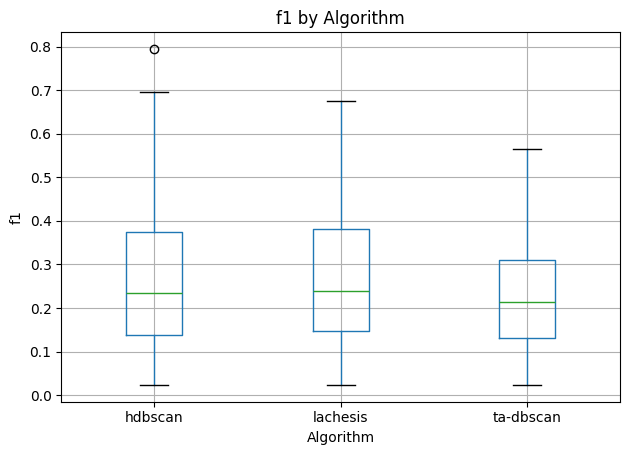

In [102]:
metrics = ["missed_fraction", "merged_fraction", "split_fraction", "precision", "recall", "f1"]

for metric in metrics:
    plt.figure()
    metrics_df.boxplot(column=metric, by='algorithm')
    plt.title(f'{metric} by Algorithm')
    plt.suptitle('')
    plt.xlabel('Algorithm')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()

plt.show()